# UK E-Commerce Customers 

The Dataset can be found [here](https://www.kaggle.com/datasets/carrie1/ecommerce-data)

Chen, D (2012). Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining. Journal of Database Marketing and Customer Strategy Management. 19 (3), pp. 197-208.

This is a transnational data set which contains all the transactions occurring between ***01/12/2010*** and ***09/12/2011*** for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

This dataframe contains 8 variables that correspond to:

* InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter **'c'**, it indicates a **cancellation**.
* StockCode: Product (item) code. Nominal, a **5-digit integral number** uniquely assigned to each **distinct product**.
* Description: Product (item) name. Nominal.
* Quantity: The quantities of each product (item) per transaction. Numeric.
* InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
* UnitPrice: Unit price. Numeric, Product price per unit in **sterling**.
* CustomerID: Customer number. Nominal, a 5-digit integral number **uniquely** assigned to each customer.
* Country: Country name. Nominal, the name of the country where each customer resides.

## Packages and Data import


In [126]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
init_notebook_mode(connected=True)
import plotly.graph_objs as go
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from yellowbrick.cluster import KElbowVisualizer
from sklearn import metrics

In [4]:
schema = {"InvoiceNo": str, "StockCode": str, "Description": str, "Quantity": "int64",
          "UnitPrice": float, "CustomerID": str, "Country": str}

df_initial = pd.read_csv("E-Commerce_uk.csv", encoding= 'unicode_escape', dtype = schema, parse_dates=['InvoiceDate'])

In [5]:
df_initial.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  
0 2010-12-01 08:26:00       2.55      17850  United Kingdom  
1 2010-12-01 08:26:00       3.39      17850  United Kingdom  
2 2010-12-01 08:26:00       2.75      17850  United Kingdom  
3 2010-12-01 08:26:00       3.39      17850  United Kingdom  
4 2010-12-01 08:26:00       3.39      17850  United Kingdom

## Data Cleaning and Preprocessing

In [6]:
df_initial.shape

(541909, 8)

In [7]:
df_initial.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
df_initial.dropna(axis = 0,inplace=True)

In [9]:
df_initial.shape

(406829, 8)

In [10]:
df_initial.describe()

Quantity      UnitPrice
count  406829.000000  406829.000000
mean       12.061303       3.460471
std       248.693370      69.315162
min    -80995.000000       0.000000
25%         2.000000       1.250000
50%         5.000000       1.950000
75%        12.000000       3.750000
max     80995.000000   38970.000000

In [11]:
# Checking for Unit Price equal to 0
df_initial[df_initial.UnitPrice == 0].head()

InvoiceNo StockCode                   Description  Quantity  \
9302     537197     22841  ROUND CAKE TIN VINTAGE GREEN         1   
33576    539263     22580  ADVENT CALENDAR GINGHAM SACK         4   
40089    539722     22423      REGENCY CAKESTAND 3 TIER        10   
47068    540372     22090       PAPER BUNTING RETROSPOT        24   
47070    540372     22553        PLASTERS IN TIN SKULLS        24   

              InvoiceDate  UnitPrice CustomerID         Country  
9302  2010-12-05 14:02:00        0.0      12647         Germany  
33576 2010-12-16 14:36:00        0.0      16560  United Kingdom  
40089 2010-12-21 13:45:00        0.0      14911            EIRE  
47068 2011-01-06 16:41:00        0.0      13081  United Kingdom  
47070 2011-01-06 16:41:00        0.0      13081  United Kingdom

In [12]:
len(df_initial[df_initial.UnitPrice == 0])

40

In [13]:
df_initial = df_initial[~df_initial.UnitPrice.isin([0])]

In [14]:
df_initial.duplicated().sum()

5225

In [15]:
df_initial.drop_duplicates(inplace=True)

In [16]:
df_initial.shape

(401564, 8)

In [17]:
len(df_initial['StockCode'].value_counts())

3684

In [18]:
summary = pd.DataFrame([{'Products': len(df_initial['StockCode'].value_counts()),    
                       'Transactions': len(df_initial['InvoiceNo'].value_counts()),
                       'Customers': len(df_initial['CustomerID'].value_counts()),  
                      }], columns = ['Products', 'Transactions', 'Customers'], index = ['quantity'])
summary

Products  Transactions  Customers
quantity      3684         22186       4371

### Deleting Cancelled Orders and correcting Order Quantities


In [19]:
# Calculating the number and percentage of cancelled orders, which start with capital C
all_orders = df_initial.InvoiceNo.nunique()
cancelled_orders = df_initial[df_initial.InvoiceNo.str.startswith("C")]["InvoiceNo"].nunique()

print("Number of cancelled orders is ", cancelled_orders)
print("Percentage of cancelled orders is %.2f percent" %((cancelled_orders/all_orders)*100))



Number of cancelled orders is  3654
Percentage of cancelled orders is 16.47 percent


In [20]:
df_initial[df_initial.InvoiceNo.str.startswith("C")].head()

InvoiceNo StockCode                       Description  Quantity  \
141   C536379         D                          Discount        -1   
154   C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235   C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236   C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237   C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   

            InvoiceDate  UnitPrice CustomerID         Country  
141 2010-12-01 09:41:00      27.50      14527  United Kingdom  
154 2010-12-01 09:49:00       4.65      15311  United Kingdom  
235 2010-12-01 10:24:00       1.65      17548  United Kingdom  
236 2010-12-01 10:24:00       0.29      17548  United Kingdom  
237 2010-12-01 10:24:00       0.29      17548  United Kingdom

In [21]:
# Checking for StockCodes that contain only letters
StockCodeList = [df_initial[df_initial['StockCode'].str.contains('^[a-zA-Z]+', regex=True)].StockCode.unique()]
StockCodeList[:][0]

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'],
      dtype=object)

In [22]:
StockCodedf = df_initial[df_initial.StockCode.isin(StockCodeList[:][0])]
StockCodedf.count()

InvoiceNo      1908
StockCode      1908
Description    1908
Quantity       1908
InvoiceDate    1908
UnitPrice      1908
CustomerID     1908
Country        1908
dtype: int64

In [23]:
# Checking the number of orders that have been cancelled with one of the above mentioned stockcodes
StockCodedf[StockCodedf.Quantity<0]

InvoiceNo StockCode      Description  Quantity         InvoiceDate  \
141      C536379         D         Discount        -1 2010-12-01 09:41:00   
9038     C537164         D         Discount        -1 2010-12-05 13:21:00   
13052    C537414      POST          POSTAGE        -1 2010-12-06 15:09:00   
14498    C537597         D         Discount        -1 2010-12-07 12:34:00   
19392    C537857         D         Discount        -1 2010-12-08 16:00:00   
...          ...       ...              ...       ...                 ...   
528087   C580726      CRUK  CRUK Commission        -1 2011-12-05 17:17:00   
531616   C580957      POST          POSTAGE        -1 2011-12-06 14:23:00   
533082   C581009         M           Manual        -1 2011-12-07 09:15:00   
534308   C581145         M           Manual        -1 2011-12-07 13:48:00   
541541   C581499         M           Manual        -1 2011-12-09 10:28:00   

        UnitPrice CustomerID         Country  
141         27.50      14527  United Kingdom  
9038        29.29      14527  United Kingdom  
13052        4.41      16861  United Kingdom  
14498      281.00      15498  United Kingdom  
19392      267.12      17340  United Kingdom  
...           ...        ...             ...  
528087    1100.44      14096  United Kingdom  
531616       4.50      12839  United Kingdom  
533082     125.00      16971  United Kingdom  
534308       9.95      17490  United Kingdom  
541541     224.69      15498  United Kingdom  

[366 rows x 8 columns]

In [24]:
# Number of entries that contain a cancelled order
df_initial[df_initial.InvoiceNo.str.startswith("C")]["InvoiceNo"].count()

8872

In most cases if an order has been cancelled, the stockcode refers to a product. In few cases we have a different StockCode such as "D" for "Discount" or "M" for "Manual". In the following I will try to identify the counterparts of these orders, so I can drop both. Given the size of the dataset, I will try reducing the size by creating a new dataset that only contains the customers, that have at least one cancelled order.  

In [25]:
# Getting the Customers that cancelled an order
CustomersCO = df_initial[(df_initial.InvoiceNo.str.startswith("C"))]["CustomerID"].unique()
len(CustomersCO)

1589

In [26]:
# Percentage of Customers how has at least one cancelled order
len(CustomersCO)/summary.Customers[0] 

0.36353237245481584

In [27]:
# Creating a new dataset with the entries of these customers

df_CustomersCO =df_initial[df_initial.CustomerID.isin(CustomersCO)]
len(df_CustomersCO)

251474

In [28]:
# Size of new dataset
len(df_CustomersCO)/len(df_initial)

0.6262364156149456

In [29]:
df_CustomersCO.sort_values("CustomerID").head()

InvoiceNo StockCode                     Description  Quantity  \
61624    C541433     23166  MEDIUM CERAMIC TOP STORAGE JAR    -74215   
61619     541431     23166  MEDIUM CERAMIC TOP STORAGE JAR     74215   
365172    568699     22634  CHILDS BREAKFAST SET SPACEBOY          2   
349398    567505     23298                  SPOTTY BUNTING         3   
349399    567505    84510A  SET OF 4 ENGLISH ROSE COASTERS        10   

               InvoiceDate  UnitPrice CustomerID         Country  
61624  2011-01-18 10:17:00       1.04      12346  United Kingdom  
61619  2011-01-18 10:01:00       1.04      12346  United Kingdom  
365172 2011-09-28 14:58:00       9.95      12352          Norway  
349398 2011-09-20 14:34:00       4.95      12352          Norway  
349399 2011-09-20 14:34:00       1.25      12352          Norway

We see above that the cancelled order has been cancelled on the same day, however an order could be cancelled the next day or
 even more due to a holiday for example. So it is safe to assume that the **InvoiceDate** of the cancelled order is after or in 
 this case "bigger" than its counterpart. 


In [30]:
df_cco = df_CustomersCO.copy(deep = True)
df_cco['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtful_entry = []

In [31]:
for row in df_CustomersCO.itertuples():
    if row[4] > 0 : continue 
        
    df_test = df_CustomersCO[(df_CustomersCO['CustomerID'] == row[7]) &
                    (df_CustomersCO['StockCode']  == row[2]) &
                    (df_CustomersCO['InvoiceDate'] < row[5]) &
                    (df_CustomersCO['Quantity']   > 0)].copy()
    
    
    if (df_test.shape[0] == 0): 
        doubtful_entry.append(getattr(row, 'Index'))
    #________________________________
    # Cancelation WITH a counterpart
    if (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cco.loc[index_order, 'QuantityCanceled'] = -row[4]
        entry_to_remove.append(index_order)
        entry_to_remove.append(getattr(row, 'Index'))

    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for val in df_test.itertuples():
            if val[4] < -row[4]: continue
            ind = getattr(val, 'Index')
            df_cco.loc[ind, 'QuantityCanceled'] = -row[4]
            entry_to_remove.append(getattr(val, 'Index'))
            entry_to_remove.append(getattr(row, 'Index'))

            break 

    #print(getattr(row, 'Index'))

In [32]:
print("Number of entries to remove is" , len(entry_to_remove))
print("Number of doubtful entries to remove is" , len(doubtful_entry))


Number of entries to remove is 15042
Number of doubtful entries to remove is 1303


In [33]:
# Percentage of partial orders, which were completely cancelled, i.e. 10 units were ordererd but completely
# cancelled afterwards.
s= df_cco.loc[entry_to_remove].groupby(['CustomerID','StockCode', "UnitPrice"]).Quantity.transform('sum').eq(0)
(len(df_cco.loc[entry_to_remove][s])/2)/len(df_initial[(df_initial.InvoiceNo.str.startswith("C"))])

0.28054553651938685

In [34]:
len(df_cco.loc[entry_to_remove][~s])

10064

In [35]:
df_cco.drop(df_cco.loc[entry_to_remove][s].index, axis=0, inplace=True)

In [36]:
df_cco.Quantity = df_cco.Quantity-df_cco.QuantityCanceled

In [37]:
df_cco.sort_values("QuantityCanceled", ascending=False).head()

InvoiceNo StockCode                         Description  Quantity  \
169123    551162     84077   WORLD WAR 2 GLIDERS ASSTD DESIGNS       240   
384013    570097     22273                FELTCRAFT DOLL MOLLY         0   
19871     537899     22328  ROUND SNACK BOXES SET OF 4 FRUITS        864   
304421    563575     21871                 SAVE THE PLANET MUG       248   
244416    558526     23170            REGENCY TEA PLATE ROSES        144   

               InvoiceDate  UnitPrice CustomerID         Country  \
169123 2011-04-26 15:45:00       0.21      12901  United Kingdom   
384013 2011-10-07 12:05:00       2.30      16029  United Kingdom   
19871  2010-12-09 10:44:00       2.55      12755           Japan   
304421 2011-08-17 15:05:00       1.06      17949  United Kingdom   
244416 2011-06-30 11:01:00       1.45      17949  United Kingdom   

        QuantityCanceled  
169123               960  
384013               720  
19871                624  
304421               576  
244416               576

In [38]:
df_cco.sort_values("QuantityCanceled", ascending=False).head()

InvoiceNo StockCode                         Description  Quantity  \
169123    551162     84077   WORLD WAR 2 GLIDERS ASSTD DESIGNS       240   
384013    570097     22273                FELTCRAFT DOLL MOLLY         0   
19871     537899     22328  ROUND SNACK BOXES SET OF 4 FRUITS        864   
304421    563575     21871                 SAVE THE PLANET MUG       248   
244416    558526     23170            REGENCY TEA PLATE ROSES        144   

               InvoiceDate  UnitPrice CustomerID         Country  \
169123 2011-04-26 15:45:00       0.21      12901  United Kingdom   
384013 2011-10-07 12:05:00       2.30      16029  United Kingdom   
19871  2010-12-09 10:44:00       2.55      12755           Japan   
304421 2011-08-17 15:05:00       1.06      17949  United Kingdom   
244416 2011-06-30 11:01:00       1.45      17949  United Kingdom   

        QuantityCanceled  
169123               960  
384013               720  
19871                624  
304421               576  
244416               576

In [39]:
df1 = df_initial.drop(index=df_CustomersCO.index, axis=0)
df2 = df_cco[df_cco.Quantity > 0]
df_clean = pd.concat([df1, df2]).drop(columns="QuantityCanceled").sort_index()
del df1, df2

In [40]:
df_clean.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  
0 2010-12-01 08:26:00       2.55      17850  United Kingdom  
1 2010-12-01 08:26:00       3.39      17850  United Kingdom  
2 2010-12-01 08:26:00       2.75      17850  United Kingdom  
3 2010-12-01 08:26:00       3.39      17850  United Kingdom  
4 2010-12-01 08:26:00       3.39      17850  United Kingdom

## Data Exploration and Visualization 

In [41]:
# Calculating spent money per order
df_clean["TotalExp"] = df_clean.Quantity*df_clean.UnitPrice

In [42]:
df_clean.replace(["EIRE", "RSA", "Channel Islands","USA"],
                 ["Ireland","South Africa", "Cayman Islands", "United States"], inplace=True)

### Sales Analysis (Country, Monthly, Daily)

In [43]:
grouped_country = df_clean.groupby("Country", as_index=False)["TotalExp"].sum()\
                            .rename(columns = {'TotalExp':'TotalRevenues'})\
                            .sort_values('TotalRevenues', ascending = False)

In [44]:
grouped_country["TotalRevenues %"] = (grouped_country["TotalRevenues"]/sum(grouped_country.TotalRevenues))*100
grouped_country["TotalRevenues % (cum)"] = grouped_country["TotalRevenues %"].cumsum()
grouped_country.head(6)

Country  TotalRevenues  TotalRevenues %  TotalRevenues % (cum)
34  United Kingdom    6836025.464        81.418271              81.418271
23     Netherlands     284937.540         3.393656              84.811927
16         Ireland     255273.910         3.040357              87.852284
13         Germany     223448.480         2.661311              90.513595
12          France     201014.690         2.394120              92.907716
0        Australia     136950.250         1.631102              94.538817

In [127]:
fig = px.pie(grouped_country, values="TotalRevenues" , names= "Country", 
             title = "<b>Revenues per Country</b><br>(Top 6 Countries account for about 95% of Total Revenue)")
fig.update_traces(textposition='inside')
fig.update_layout(uniformtext_minsize = 6, uniformtext_mode='hide')
fig.update_layout(title_x=0.5)
fig.show()


In [128]:
# Importing ISO alpha 3 codes for the countries to use the
#countries_code = pd.read_csv("countries_codes.csv")
#countries_code

In [129]:
#codes = countries_code[countries_code.Country.isin(grouped_country["Country"])][["Country","Alpha-3 code"]]
#codes["Alpha-3 code"] = codes["Alpha-3 code"].str.replace('"', '')
#codes.rename(columns= {"Alpha-3 code":"Code"}, inplace = True)
#grouped_country = pd.merge(grouped_country, codes, on= "Country")

In [130]:
#grouped_country.head()

In [131]:
fig = px.choropleth(grouped_country[~(grouped_country.Country=="United Kingdom")], locations="Country", locationmode = "country names",
                    color="TotalRevenues", # lifeExp is a column of gapminder
                    hover_name="Country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma,
                   title = "Foreign Sales Revenues (Outside UK)")
fig.update_layout(title_x=0.5)
fig.show()

In [132]:
grouped_sales =df_clean.loc[:, ("CustomerID","InvoiceNo", "Quantity", "InvoiceDate", "TotalExp")]
grouped_sales.insert(4, "Year", df_clean['InvoiceDate'].dt.year)
grouped_sales.insert(5, "Month", df_clean['InvoiceDate'].dt.month)
grouped_sales.insert(6, "DayofWeek", df_clean['InvoiceDate'].dt.dayofweek)

In [133]:
grouped_sales.head()

CustomerID InvoiceNo  Quantity         InvoiceDate  Year  Month  DayofWeek  \
0      17850    536365         6 2010-12-01 08:26:00  2010     12          2   
1      17850    536365         6 2010-12-01 08:26:00  2010     12          2   
2      17850    536365         8 2010-12-01 08:26:00  2010     12          2   
3      17850    536365         6 2010-12-01 08:26:00  2010     12          2   
4      17850    536365         6 2010-12-01 08:26:00  2010     12          2   

   TotalExp  
0     15.30  
1     20.34  
2     22.00  
3     20.34  
4     20.34

In [134]:
monthly_sales = grouped_sales.groupby(["Year", "Month"], as_index=False)["TotalExp"].sum()
monthly_sales['Year'] = monthly_sales['Year'].astype(str)
monthly_sales

Year  Month     TotalExp
0   2010     12   556570.560
1   2011      1   459021.880
2   2011      2   439737.920
3   2011      3   582836.120
4   2011      4   456103.321
5   2011      5   662499.590
6   2011      6   607406.930
7   2011      7   586817.441
8   2011      8   622971.820
9   2011      9   940459.912
10  2011     10   995702.900
11  2011     11  1138196.350
12  2011     12   347856.380

In [135]:
fig = px.bar(monthly_sales,  x='Month', y='TotalExp', barmode  = "group",  color= "Year",  title = "Monthly Sales")
fig.update_layout(yaxis_title = "Revenues")
fig.update_layout(title_x=0.5)
fig.show()

In [136]:
daily_sales = grouped_sales.groupby("DayofWeek",as_index=False)["TotalExp"].sum()\
                           .rename(columns = {'DayofWeek':'Weekday', "TotalExp":"Total Revenues"})
daily_sales["Weekday"] = daily_sales.Weekday+1
daily_sales

Weekday  Total Revenues
0        1     1331224.431
1        2     1574779.921
2        3     1559927.450
3        4     1916125.580
4        5     1240611.561
5        7      773512.181

In [137]:
fig = px.bar(daily_sales,  x='Weekday', y='Total Revenues', barmode  = "group",  
             title = "Daily Sales")
fig.update_layout(xaxis_title = "Weekday" , yaxis_title = "Revenues")
fig.show()

### Customers and Orders Analysis

In [56]:
Customers = df_clean.groupby(["CustomerID", "Country"], as_index=False)\
                      .agg({"InvoiceDate": "max", "InvoiceNo": pd.Series.nunique,
                            "Quantity": "sum", "TotalExp":"sum"})\
          .rename(columns = {"InvoiceDate":"LatestOrderDate", "InvoiceNo":"NumOrders",
                             "Quantity":"Sum_Quantity", "TotalExp":"Total_Expenditure"})

In [57]:
Customers.head()

CustomerID  Country     LatestOrderDate  NumOrders  Sum_Quantity  \
0      12347  Iceland 2011-12-07 15:52:00          7          2458   
1      12348  Finland 2011-09-25 13:13:00          4          2341   
2      12349    Italy 2011-11-21 09:51:00          1           631   
3      12350   Norway 2011-02-02 16:01:00          1           197   
4      12352   Norway 2011-11-03 14:37:00          7           473   

   Total_Expenditure  
0            4310.00  
1            1797.24  
2            1757.55  
3             334.40  
4            2385.71

In [58]:
fig = px.scatter(Customers, x="NumOrders", y = 'Total_Expenditure', 
                  log_x = True,  log_y = True, title = "Relationship between Quantity and Expenditure")
fig.update_layout(title_x=0.5)
fig.show()

In [59]:
fig = px.histogram(Customers, x="Total_Expenditure", marginal  = "violin",  nbins=50,  log_y = True)
fig.update_layout(bargap=0.2)
fig.show()

In [60]:
# Exploring Distribution for under $100k
fig = px.histogram(Customers[Customers.Total_Expenditure < 100000], 
                   x="Total_Expenditure", marginal  = "violin", nbins=50,  log_y = True)
fig.update_layout(bargap=0.2)
fig.show()

In [61]:
fig = px.box(Customers, x="Total_Expenditure",  points = "all",  orientation = "h", log_x = True)
fig.show()

In [62]:
fig = px.histogram(Customers, x="NumOrders", marginal  = "violin",  nbins=50,  log_y = True)
fig.update_layout(bargap=0.2)
fig.show()

In [63]:
Orders = df_clean.groupby('StockCode', as_index=False)\
          .agg({"InvoiceNo":"count", "Quantity": "sum", "TotalExp":"sum"})\
          .rename(columns = {"InvoiceNo":"NumOrders","Quantity":"SoldQuant", "TotalExp":"TotalRev"})

Orders = Orders[~Orders.StockCode.isin(StockCodeList[:][0])]

Orders = Orders.sort_values("TotalRev", ascending=False)
Orders["TotalRev %"] = (Orders["TotalRev"]/sum(Orders.TotalRev))*100
Orders["TotalRev % (cum)"] = Orders.sort_values("TotalRev", ascending=False)["TotalRev %"].cumsum()

In [64]:
# Dropping non Products such as POST or Bank Charges 
Orders.head(10)

StockCode  NumOrders  SoldQuant   TotalRev  TotalRev %  TotalRev % (cum)
1286     22423       1678      11696  134549.05    1.628111          1.628111
3228    85123A       2013      34190   93936.30    1.136676          2.764787
3214    85099B       1606      45088   83282.05    1.007754          3.772541
2590     47566       1380      15021   67667.33    0.818808          4.591350
3054     84879       1392      35217   56336.97    0.681705          5.273055
1917     23084        820      27046   51048.11    0.617708          5.890763
2745     79321        519       9566   45915.41    0.555599          6.446362
983      22086        997      15224   41645.48    0.503931          6.950293
375      21137        311      11388   38997.41    0.471888          7.422181
1086     22197       1057      48731   36886.17    0.446341          7.868522

In [65]:
fig = px.scatter(Orders, x="TotalRev", y = 'NumOrders', 
                  log_x = True,  log_y = True, title = "Relationship between Quantity and Revenues")
fig.update_layout(xaxis_title = "Total Revenues", yaxis_title = "Number of Orders")
fig.update_layout(title_x=0.5)
fig.show()

In [66]:
Customers.head()

CustomerID  Country     LatestOrderDate  NumOrders  Sum_Quantity  \
0      12347  Iceland 2011-12-07 15:52:00          7          2458   
1      12348  Finland 2011-09-25 13:13:00          4          2341   
2      12349    Italy 2011-11-21 09:51:00          1           631   
3      12350   Norway 2011-02-02 16:01:00          1           197   
4      12352   Norway 2011-11-03 14:37:00          7           473   

   Total_Expenditure  
0            4310.00  
1            1797.24  
2            1757.55  
3             334.40  
4            2385.71

### RFM Analysis

In [67]:
RFM_Model = Customers.iloc[:, [0,2,3,5]]
RFM_Model.insert(2, "end_timestamp", pd.Timestamp("2011-12-10 00:00:00"))
RFM_Model.head()

CustomerID     LatestOrderDate end_timestamp  NumOrders  Total_Expenditure
0      12347 2011-12-07 15:52:00    2011-12-10          7            4310.00
1      12348 2011-09-25 13:13:00    2011-12-10          4            1797.24
2      12349 2011-11-21 09:51:00    2011-12-10          1            1757.55
3      12350 2011-02-02 16:01:00    2011-12-10          1             334.40
4      12352 2011-11-03 14:37:00    2011-12-10          7            2385.71

In [68]:
RFM_Model['diff'] = round(((RFM_Model['end_timestamp']-RFM_Model['LatestOrderDate']).dt.total_seconds()/86400), 2)
RFM_Model.drop(["LatestOrderDate", "end_timestamp"], axis=1, inplace=True)

In [69]:
RFM_Model.head()

CustomerID  NumOrders  Total_Expenditure    diff
0      12347          7            4310.00    2.34
1      12348          4            1797.24   75.45
2      12349          1            1757.55   18.59
3      12350          1             334.40  310.33
4      12352          7            2385.71   36.39

In [70]:
RFM_Model = RFM_Model.loc[:,("CustomerID", "diff", "NumOrders", "Total_Expenditure")]\
                     .rename(columns={"diff":"R", "NumOrders":"F", "Total_Expenditure":"M"})
RFM_Model.head()

CustomerID       R  F        M
0      12347    2.34  7  4310.00
1      12348   75.45  4  1797.24
2      12349   18.59  1  1757.55
3      12350  310.33  1   334.40
4      12352   36.39  7  2385.71

In [71]:
RFM = RFM_Model.drop("CustomerID", axis=1)

In [72]:
std_data = StandardScaler().fit_transform(RFM) # normalizing the data 
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(std_data)

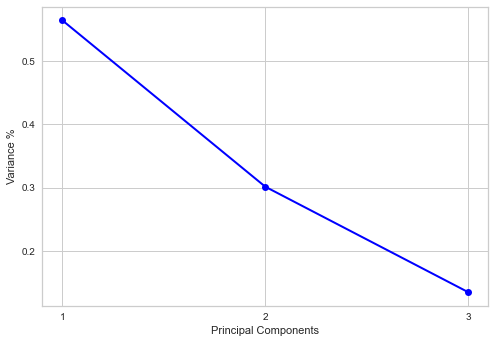

In [73]:
PC = range(1, pca.n_components_+1)
#plt.bar(PC, pca.explained_variance_ratio_, color='gold')
plt.plot(PC, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.xlabel('Principal Components')
plt.ylabel('Variance %')
plt.xticks(PC)

# Putting components in a dataframe for later
PCA_components = pd.DataFrame(principalComponents)

In [74]:
pd.DataFrame(std_data, columns=RFM.columns).head(2)


R         F         M
0 -0.902955  0.361479  0.283014
1 -0.173849 -0.032012 -0.016648

In [75]:
pca_out = PCA().fit(std_data)

# Get the component variance
# Proportion of Variance (from PC1 to PC3)
pca_out.explained_variance_ratio_

array([0.56401699, 0.30128647, 0.13469654])

In [76]:
# component loadings or weights (correlation coefficient between original variables and the component) 
# component loadings represents the elements of the eigenvector
# the squared loadings within the PCs always sums to 1
loadings = pca_out.components_
num_pc = pca_out.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = RFM.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df

PC1       PC2       PC3
variable                              
R        -0.375242  0.910766  0.172331
F         0.674527  0.140785  0.724702
M         0.635773  0.388181 -0.667165

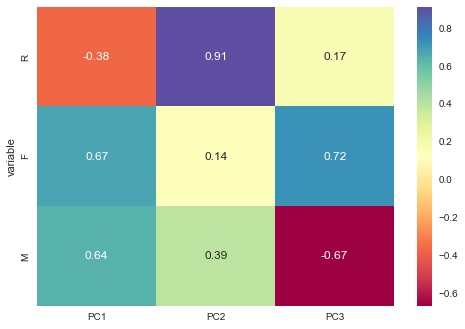

In [77]:
ax = sns.heatmap(loadings_df, annot=True, cmap='Spectral')
plt.show()

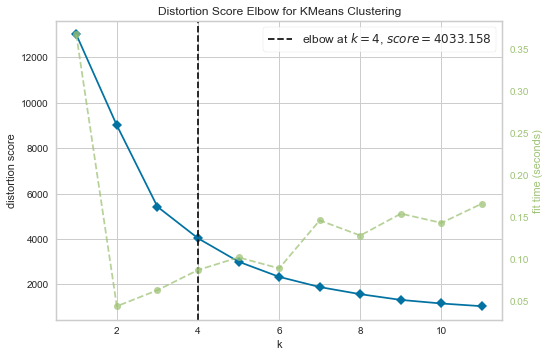

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [78]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))
visualizer.fit(PCA_components)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [91]:
model = KMeans(n_clusters=4)
model.fit(PCA_components.iloc[:,:2])

labels = model.predict(PCA_components.iloc[:,:2])

In [92]:
lab= {str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)}

lab['color'] = 'Cluster'

fig = px.scatter_matrix(principalComponents, labels=lab, dimensions=range(3), color = labels)
fig.update_traces(diagonal_visible=False)
fig.show()

In [93]:
total_var = pca.explained_variance_ratio_[0:3].sum() * 100

fig = px.scatter_3d(
    principalComponents, x=0, y=1, z=2, color=labels,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

In [98]:
RFM_Model.insert(4, "cluster", labels.reshape(-1,1))

In [99]:
RFM_Model.cluster = RFM_Model.cluster + 1

In [100]:
RFM_Model.head()

CustomerID       R  F        M  cluster
0      12347    2.34  7  4310.00        4
1      12348   75.45  4  1797.24        4
2      12349   18.59  1  1757.55        4
3      12350  310.33  1   334.40        2
4      12352   36.39  7  2385.71        4

In [101]:
fig = px.scatter_matrix(RFM_Model.drop(columns="CustomerID"), labels=["R", "F", "M"], dimensions=["R", "F", "M"],  color = "cluster")
fig.update_traces(diagonal_visible=False)
fig.show()

In [102]:
fig = px.scatter_3d(RFM_Model, x="R", y="M", z="F", log_x = True, log_y = True, log_z=True, color="cluster")
fig.show()

In [103]:
fig = px.scatter(RFM_Model, x="F", y="R", log_x = True, log_y = True, color="cluster")
fig.show()

In [104]:
RFM_Model.groupby("cluster").mean()

R          F              M
cluster                                      
1         11.328246  23.771930   13674.843626
2        247.821944   1.538889     489.416306
3          8.127273  93.454545  124194.222727
4         43.270856   3.788806    1354.727238

**Clusters Ranking**

In [105]:
RFM_Model.groupby("cluster").mean().sort_values(["R", "F", "M"])

R          F              M
cluster                                      
3          8.127273  93.454545  124194.222727
1         11.328246  23.771930   13674.843626
4         43.270856   3.788806    1354.727238
2        247.821944   1.538889     489.416306